# Selecting and object and creating a cutout

Based partly on 
* https://pipelines.lsst.io/getting-started/index.html#getting-started-tutorials 
* https://github.com/RobertLuptonTheGood/notebooks/blob/master/Demos/Colour%20Images.ipynb

In [1]:
import numpy as np
from astropy.visualization import ZScaleInterval

import lsst.daf.persistence as dafPersist
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

In [20]:
# Set plotting defaults
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (13, 8)
zscale = ZScaleInterval()

In [3]:
butler = dafPersist.Butler('/home/shared/twinkles/output_data_v2')

/opt/lsst/software/stack/python/miniconda3-4.3.21/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [4]:
# Display the available keys
print(butler.getKeys('calexp'))
print(dir(butler))
#butler.queryMetadata('calexp', butler.getKeys('calexp'))[0]

{'visit': <class 'int'>, 'filter': <class 'str'>, 'raft': <class 'str'>, 'sensor': <class 'str'>}
['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_addParents', '_assignDefaultMapper', '_connectParentRepoDatas', '_convertV1Args', '_getBypassFunc', '_getCfgs', '_getDefaultMapper', '_getOldButlerRepositoryCfg', '_getParentRepoData', '_getParentVal', '_getParents', '_getRepositoryCfg', '_initArgs', '_locate', '_processInputArguments', '_read', '_repos', '_resolveDatasetTypeAlias', '_setAndVerifyParentsLists', '_setDefaultMapper', '_setParentRegistry', '_setRepoDataTags', 'dataRef', 'datasetExists', 'datasetTypeAliasDict', 'defineAlias', 'get', 'getKeys', 'getMapperClass', 'getUri', 'log', 'persist

In [5]:
# Count the number of images in each filter
# Is queryMetadata faster than subset?
visit_array, filter_array = map(np.array, zip(*butler.queryMetadata('calexp', ['visit', 'filter'])))
for filter in np.unique(filter_array):
    print(filter, np.sum(filter_array == filter))

g 10
i 10
r 10
u 10
y 10
z 10


In [6]:
subset = butler.subset('src')
dataid = subset.cache[4]
#print(subset.cache[4])
#print(dir(butler))
#help(butler.get)
#my_src = butler.get('src', dataId={'visit': 234})
my_src = butler.get('src', dataId=dataid)
my_calexp = butler.get('calexp', dataId=dataid)
my_wcs = my_calexp.getWcs()
my_calib = my_calexp.getCalib()
my_calib.setThrowOnNegativeFlux(False)

In [7]:
my_src.schema.getNames()

{'base_Blendedness_abs_child_xx',
 'base_Blendedness_abs_child_xy',
 'base_Blendedness_abs_child_yy',
 'base_Blendedness_abs_flux',
 'base_Blendedness_abs_flux_child',
 'base_Blendedness_abs_flux_parent',
 'base_Blendedness_abs_parent_xx',
 'base_Blendedness_abs_parent_xy',
 'base_Blendedness_abs_parent_yy',
 'base_Blendedness_flag',
 'base_Blendedness_flag_noCentroid',
 'base_Blendedness_flag_noShape',
 'base_Blendedness_old',
 'base_Blendedness_raw_child_xx',
 'base_Blendedness_raw_child_xy',
 'base_Blendedness_raw_child_yy',
 'base_Blendedness_raw_flux',
 'base_Blendedness_raw_flux_child',
 'base_Blendedness_raw_flux_parent',
 'base_Blendedness_raw_parent_xx',
 'base_Blendedness_raw_parent_xy',
 'base_Blendedness_raw_parent_yy',
 'base_CircularApertureFlux_12_0_flag',
 'base_CircularApertureFlux_12_0_flag_apertureTruncated',
 'base_CircularApertureFlux_12_0_flag_sincCoeffsTruncated',
 'base_CircularApertureFlux_12_0_flux',
 'base_CircularApertureFlux_12_0_fluxSigma',
 'base_Circular

16.082371942826086
1168


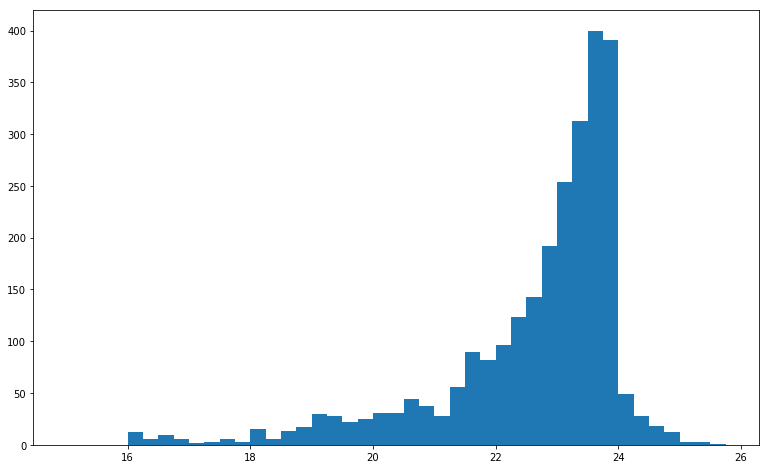

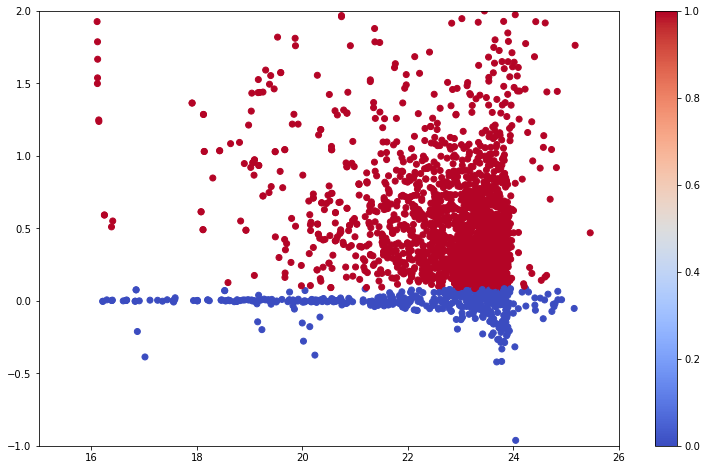

In [21]:
#print(dir(my_src))S
#psf_mag = my_calib.getMagnitude(my_src['base_PsfFlux_apCorr'])
psf_mag = my_calib.getMagnitude(my_src.getPsfFlux())
psf_mag = np.where(np.isfinite(psf_mag), psf_mag, 9999.) # Set sentinel value

cm_mag = my_calib.getMagnitude(my_src.getModelFlux())
cm_mag = np.where(np.isfinite(cm_mag), cm_mag, 9999.) # Set sentinel value

plt.figure()
#plt.yscale('log', nonposy='clip')
plt.hist(np.nan_to_num(psf_mag), bins=np.arange(15., 26., 0.25))

plt.figure()
plt.scatter(psf_mag, psf_mag - cm_mag, c=my_src['base_ClassificationExtendedness_value'], cmap='coolwarm')
plt.colorbar()
plt.xlim(15., 26.)
plt.ylim(-1., 2.)

#my_src.schema.getNames()
#my_src['coord_ra'].shape
#print(99. * (my_src['base_ClassificationExtendedness_value'] == 0.).astype(int)))
#index = np.argmin(np.where(my_src['base_ClassificationExtendedness_value'] == 0, psf_mag, np.nan))
index = np.argmin(psf_mag)
print(psf_mag[index])
#index = np.argmin(psf_mag + (99. * (my_src['base_ClassificationExtendedness_value'] == 0.).astype(int)))
print(index)
ra_target, dec_target = my_src['coord_ra'][index], my_src['coord_dec'][index] # Radians
#print(dir(afwCoord))
#print(dir(afwGeom))
#print(help(afwGeom.Point2D))
#coord = afwCoord.Coord(ra_target * afwGeom.degrees, dec_target * afwGeom.degrees)
#coord = afwGeom.Point2D(ra_target * afwGeom.degrees, dec_target * afwGeom.degrees)
coord = afwGeom.SpherePoint(ra_target, dec_target, afwGeom.radians) # Is this really the preferred way to do this?
#print(coord)
#dir(ra_target)
#print(np.degrees(np.max(my_src['coord_dec'])) - np.degrees(np.min(my_src['coord_dec'])))
#13. / 60.
#99. * (my_src['base_ClassificationExtendedness_value'] == 1.).astype(int)
#np.where(np.isfinite(psf_mag), psf_mag, 9999.)

In [9]:
#my_calexp = butler.get('calexp', dataId={'visit': 234})
#subset = butler.subset('md')
#subset = butler.subset('wcs')
#subset.cache
#my_wcs = butler.get('wcs', dataId={'visit': 234})

In [18]:
cutoutSize = afwGeom.ExtentI(100, 100)
#my_wcs.skyToPixel(coord)
xy = afwGeom.PointI(my_wcs.skyToPixel(coord))
bbox = afwGeom.BoxI(xy - cutoutSize//2, cutoutSize)
#print(bbox)
#print(dir(my_calexp))
#print(help(butler.get))
#my_calexp.getBBox()
image = butler.get('calexp', immediate=True, dataId=dataid).getMaskedImage()
#image = butler.get('calexp', bbox=bbox, immediate=True, dataId=dataid).getMaskedImage() # This seems the more attactive approach

In [11]:
#import lsst.afw.display as afwDisplay
#print(dir(afwDisplay))

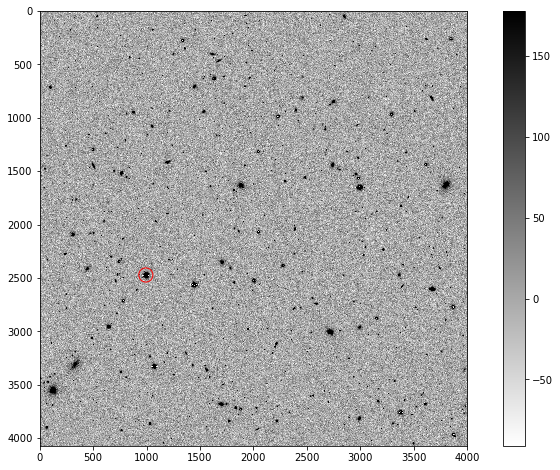

In [30]:
vmin, vmax = zscale.get_limits(image.image.array)
plt.imshow(image.image.array, vmin=vmin, vmax=vmax, cmap='binary')
plt.colorbar()
#dir(xy)
plt.scatter(xy.getX(), xy.getY(), color='none', edgecolor='red', s=200)
#my_calexp.image.array

In [13]:
#image = my_calexp.getMaskedImage()

In [14]:
#dir(image)

In [15]:
#d = dict([('b', 2)])
#d.setdefault('a', None)
#print(d)

(100, 100)


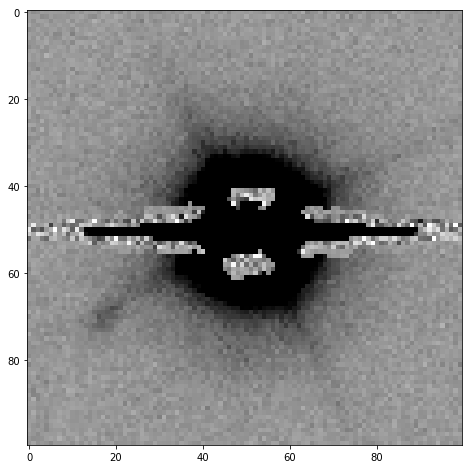

In [31]:
# Make a cutout image
my_calexp_cutout = my_calexp.Factory(my_calexp, bbox, afwImage.LOCAL)
print(my_calexp_cutout.getDimensions())
vmin, vmax = zscale.get_limits(my_calexp_cutout.image.array)
plt.imshow(my_calexp_cutout.image.array, vmin=vmin, vmax=vmax, cmap='binary')